# Batch IK convergence analysis
This notebook analysis the emprirical convergence properties of the two batch ik methods - the jacobian psuedo inverse method and the auto-diff method 

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
from time import time
from typing import Callable
from dataclasses import dataclass

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from jrl.utils import to_torch, set_seed
from jrl.robot import Robot
from jrl.robots import Panda
from jrl.math_utils import geodesic_distance_between_quaternions

set_seed(0)
assert torch.cuda.is_available()

set_seed() - random int:  541


In [3]:
def solution_pose_errors(robot: Robot, solutions: torch.Tensor, target_poses: torch.Tensor):
    """Return the L2 and angular errors of calculated ik solutions for a given target_pose. Note: this function expects
    multiple solutions but only a single target_pose. All of the solutions are assumed to be for the given target_pose
    """
    ee_pose_ikflow = robot.forward_kinematics(solutions[:, 0 : robot.ndof])
    l2_errors = torch.norm(ee_pose_ikflow[:, 0:3] - target_poses[:, 0:3], dim=1)
    ang_errors = geodesic_distance_between_quaternions(ee_pose_ikflow[:, 3:], target_poses[:, 3:])
    return l2_errors, ang_errors


In [4]:
def fn_mean_std(fn: Callable, k: int):
    runtimes = []
    for _ in range(k):
        t0 = time()
        fn()
        runtimes.append(1000 * (time() - t0))
    return np.mean(runtimes), np.std(runtimes)

@dataclass
class OptimStepEval:
    name: str
    mean_t_err: float
    mean_R_err: float
    t_err_std: float
    R_err_std: float
    alpha: float
    t_elapsed: float

In [5]:
robot = Panda()

WorldModel::LoadRobot: /home/jstm/.cache/jrl/urdfs/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
Geometry: Loading 12 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/link0.dae into Group
Geometry: Loading 4 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/link3.dae into Group
Geometry: Loading 4 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/link4.dae into Group
Geometry: Loading 3 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/link5.dae into Group
Geometry: Loading 17 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/link6.dae into Group
Geometry: Loading 8 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/link7.dae into Group
Geometry: Loading 5 meshes from /home/jstm/Projects/Jrl/jrl/urdfs/panda/meshes/visual/hand.dae

In [6]:
methods = {
    "Jacobian Psuedo-Inverse": lambda x, target, alpha: robot.inverse_kinematics_step_jacobian_pinv(target, x, alpha=alpha),
    # "torch.AutoDiff": lambda x, target, alpha: robot.inverse_kinematics_autodiff_single_step_batch_pt(target, x, alpha=alpha),
    "Levenberg-Marquardt": lambda x, target, alpha: robot.inverse_kinematics_step_levenburg_marquardt(target, x, alpha=alpha),
    "Levenberg-Marquardt Cholesky": lambda x, target, alpha: robot.inverse_kinematics_step_levenburg_marquardt_cholesky(target, x, alpha=alpha),
}

n_solutions = 500

goalpose_angles, goalposes = robot.sample_joint_angles_and_poses(n_solutions)
goalposes_cuda = to_torch(goalposes.copy(), device="cuda")
x_pt = to_torch(goalpose_angles.copy()).cuda() # close to solution
x_pt = robot.clamp_to_joint_limits(x_pt + torch.randn_like(x_pt) / 10)

df = pd.DataFrame(
    columns=[
        "method", 
        "alpha", 
        "number of solutions", 
        "total runtime (s)", 
        "number of optimization steps", 
        "final mean translational error (cm)", 
        "final mean rotational error (deg)"
    ])

all_loss_histories = []
for name, method in methods.items():
    # for alpha in [0.25, 0.5, 0.75, 1.0]:
    for alpha in [0.1, 0.25, 0.5, 1.0]:
        print(name, alpha)
        loss_history = []
        x_pt_i = x_pt.detach()

        t_elapsed = 0
        counter = 0

        while (len(loss_history) == 0 or loss_history[-1].mean_t_err > 0.1) and counter < 20:
            l2_errors, ang_errors = solution_pose_errors(robot, x_pt_i, goalposes_cuda)
            l2_errors = 100 * l2_errors
            ang_errors = torch.rad2deg(ang_errors)

            loss_history.append(
                OptimStepEval(
                    name=name,
                    mean_t_err=l2_errors.mean().item(),
                    mean_R_err=ang_errors.mean().item(),
                    t_err_std=l2_errors.mean().item(),
                    R_err_std=ang_errors.mean().item(),
                    alpha=alpha,
                    t_elapsed=t_elapsed))

            t0i = time()
            x_pt_i = method(x_pt_i, goalposes_cuda, alpha)
            t_elapsed += time() - t0i
            counter += 1 

        new_row = [name, alpha, n_solutions, t_elapsed, counter, loss_history[-1].mean_t_err, loss_history[-1].mean_R_err]
        df.loc[len(df)] = new_row
        all_loss_histories.append(loss_history)


df = df.sort_values(by=["method", "alpha"])
df_success = df[df['final mean translational error (cm)'] < 0.1]
df_success.sort_values(by=["total runtime (s)"])

Jacobian Psuedo-Inverse 0.1
Jacobian Psuedo-Inverse 0.25
Jacobian Psuedo-Inverse 0.5
Jacobian Psuedo-Inverse 1.0
Levenberg-Marquardt 0.1
Levenberg-Marquardt 0.25
Levenberg-Marquardt 0.5
Levenberg-Marquardt 1.0
Levenberg-Marquardt Cholesky 0.1
Levenberg-Marquardt Cholesky 0.25
Levenberg-Marquardt Cholesky 0.5
Levenberg-Marquardt Cholesky 1.0


,method,alpha,number of solutions,total runtime (s),number of optimization steps,final mean translational error (cm),final mean rotational error (deg)
11,Levenberg-Marquardt Cholesky,1.00,500,0.140281,4,0.083206,0.145653
7,Levenberg-Marquardt,1.00,500,0.146046,4,0.083198,0.145601
10,Levenberg-Marquardt Cholesky,0.50,500,0.287367,8,0.097175,0.149010
6,Levenberg-Marquardt,0.50,500,0.300945,8,0.097166,0.148975
2,Jacobian Psuedo-Inverse,0.50,500,0.579023,9,0.092566,0.214021
9,Levenberg-Marquardt Cholesky,0.25,500,0.650779,18,0.091732,0.135403
5,Levenberg-Marquardt,0.25,500,0.665830,18,0.091733,0.135780
1,Jacobian Psuedo-Inverse,0.25,500,1.183721,18,0.092558,0.153354


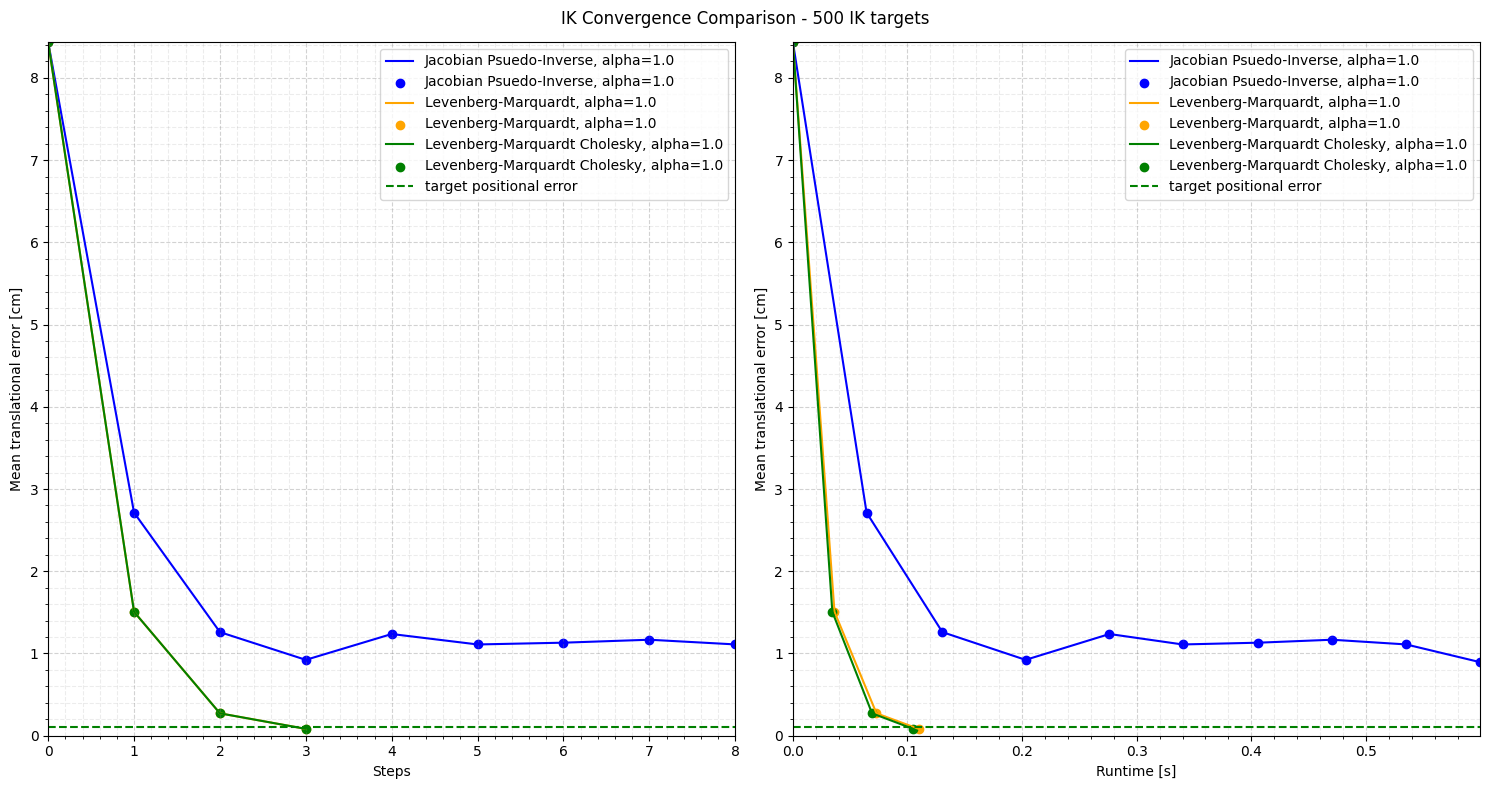

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle(f"IK Convergence Comparison - {n_solutions} IK targets")


TARGET_t_err = 0.1
max_n_steps_plotted = 10

color_map = {
    "Jacobian Psuedo-Inverse": "blue",
    "Levenberg-Marquardt": "orange",
    "Levenberg-Marquardt Cholesky": "green",
    "torch.AutoDiff": "red"
}
linestyle_map = {
    "1.0": "solid",
    "0.5": "dashed",
    "0.25": "dotted",
    "0.1": "dashdot"
}


t_max = 0.0
err_max = 0.0
for loss_history in all_loss_histories:
    if loss_history[0].alpha < 0.501: # these ones do poorly
        continue
    tsteps = np.arange(len(loss_history))
    telapsed = np.array([ose.t_elapsed for ose in loss_history])
    mean_ts = np.array([ose.mean_t_err for ose in loss_history])
    std_ts = np.array([ose.t_err_std for ose in loss_history])
    if len(loss_history) >= max_n_steps_plotted:
        tsteps = tsteps[0:max_n_steps_plotted]
        telapsed = telapsed[0:max_n_steps_plotted]
        mean_ts = mean_ts[0:max_n_steps_plotted]
        std_ts = std_ts[0:max_n_steps_plotted]

    t_max = max(t_max, telapsed.max())
    err_max = max(err_max, mean_ts.max())

    color = color_map[loss_history[0].name]
    linestyle = linestyle_map[str(loss_history[0].alpha)]
    label = f"{loss_history[0].name}, alpha={loss_history[0].alpha}"

    axs[0].plot(tsteps, mean_ts, color=color, linestyle=linestyle, label=label)
    axs[1].plot(telapsed, mean_ts, color=color, linestyle=linestyle, label=label)
    axs[0].scatter(tsteps, mean_ts, color=color, linestyle=linestyle, label=label)
    axs[1].scatter(telapsed, mean_ts, color=color, linestyle=linestyle, label=label)

axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Mean translational error [cm]")
axs[0].set_ylim(0, err_max)
axs[0].set_xlim(0, max_n_steps_plotted-2)

axs[1].set_ylabel("Mean translational error [cm]")
axs[1].set_xlim(0, t_max)
axs[1].set_ylim(0, err_max)


axs[0].plot([0, 1000], [TARGET_t_err, TARGET_t_err], color="green", linestyle="dashed", label="target positional error")
axs[1].plot([0, 1000], [TARGET_t_err, TARGET_t_err], color="green", linestyle="dashed", label="target positional error")
axs[0].grid(True, which="both", ls="--", c="gray", alpha=0.35)
axs[1].grid(True, which="both", ls="--", c="gray", alpha=0.35)
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[0].grid(True, which="minor", ls="--", c="gray", alpha=0.15)
axs[1].grid(True, which="minor", ls="--", c="gray", alpha=0.15)
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Runtime [s]")
fig.tight_layout()
fig.savefig("../media/ik_convergence_benchmark.png", bbox_inches="tight")